1. Loading
1. Remove slow drift
1. 50Hz notch filter
1. ICA

In [2]:
import os
import numpy as np
import mne
from mne.preprocessing import (
    ICA,
    corrmap,
    create_ecg_epochs,
    create_eog_epochs
)
from hydra import initialize, compose
from nd.utils.gTecUtils.gtec_preproc import eeg_subset_fromTrigger
from nd.utils.preproc_utils import get_face2brain_data_paths
import matplotlib
matplotlib.use('TkAgg')
%matplotlib tk


with initialize(version_base=None, config_path="../configs/"):
    args = compose(config_name="stylegan.yaml")

## Loading

In [3]:
video_paths, video_times_paths, eeg_paths = get_face2brain_data_paths(args.data_root)

assert len(video_paths) == len(video_times_paths) == len(eeg_paths)
print(f"Sessions: {len(video_paths)}")

Sessions: 32


In [ ]:
i = 31

eeg_path = eeg_paths[i]
print(eeg_path)

eeg_raw, eeg_times, (ch_names, sfreq, montage) = eeg_subset_fromTrigger(args, eeg_path)
print(eeg_raw.shape)

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")

eeg_raw = mne.io.RawArray(eeg_raw, info)
eeg_raw = eeg_raw.set_montage(montage)

save_path = os.path.join("../driving_ica", eeg_path.split("/")[-3]) + "/"
os.makedirs(save_path, exist_ok=True)

In [ ]:
eeg_raw.plot()

## Remove slow drift

In [201]:
eeg_highpass = eeg_raw.copy().filter(l_freq=1, h_freq=None)

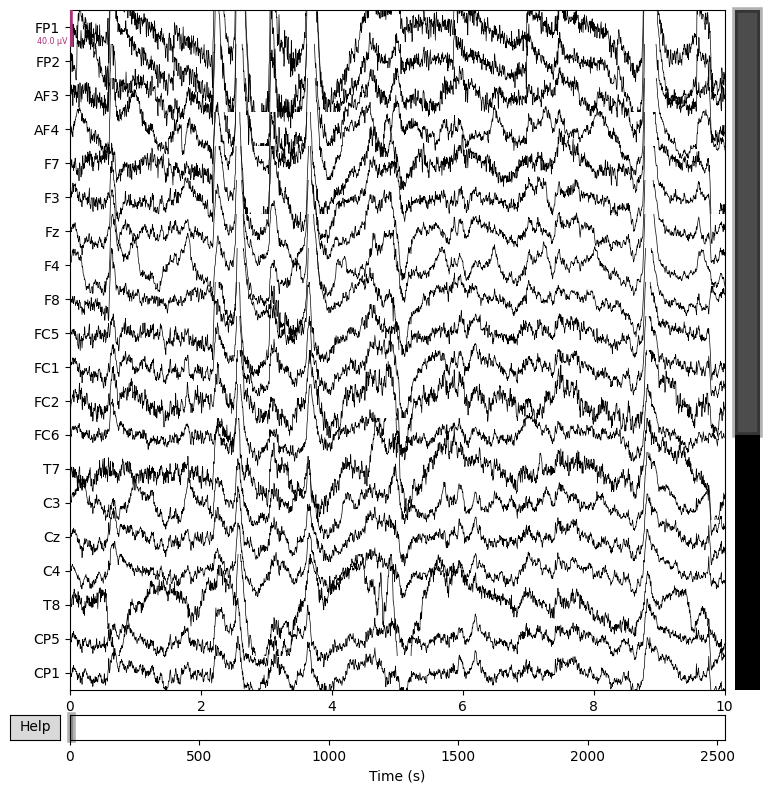

In [92]:
eeg_highpass.plot()

## 50Hz notch filter

In [202]:
eeg_notch = eeg_highpass.copy().notch_filter(freqs=(50, 100))

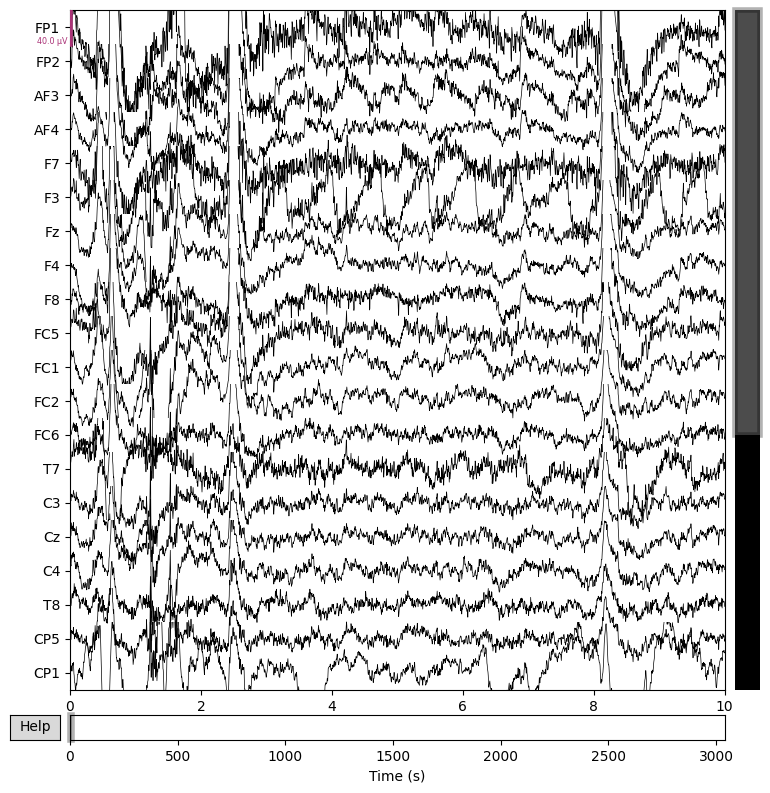

In [ ]:
eeg_notch.plot()

# ICA

- 統計的独立性が最大になる成分を見つける

- 脳活動，眼球運動，筋電，その他ノイズ源など
  - まばたきは毎回パターンが同じなので分離しやすい

### 二つの使い道

1. 分離したノイズを除去する

1. 脳シグナルと思われるcomponentを解析する

## MNEのICA

- FastICA (default)
- Picard
- Infomax

<img src="https://mne.tools/stable/_images/graphviz-7483cb1cf41f06e2a4ef451b17f073dbe584ba30.png">

- EEG($\mu V$やmV)やMEG(Tesla)などのユニットが違うのを合わせるためのpre-whitening．全チャンネルのStdで割る
- PCAの最初の`n_components`を使ってICAをやる．説明分散の割合($(0,1)$)で指定することも可能


# ICAによるノイズ除去

主に除去したいのはEOG(Electro-oculogram; 眼電)とECG(Electro-cardiogram; 心電)．


### Fitting ICA

- ICAを行う前にslow driftを取り除くのが重要（前のノートブックでやった）

`n_components`が，ICAにPCAの最初の何PCを使うか．

ECGとEOGが強く出ている（分散が大きい）データなので，それらはおそらくPCAの最初の方のPCで説明される．

- ICAは確率的なので`random_state`を指定．

In [203]:
ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(eeg_notch)
ica

Method,fastica
Fit,38 iterations on raw data (669067 samples)
ICA components,15
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


### 各componentによって説明される分散の確認

In [29]:
for i in range(ica.n_components_):

    explained_var_ratio = ica.get_explained_variance_ratio(
        eeg_notch,
        components=[i],
        ch_type='eeg'
    )

    ratio_percent = round(100 * explained_var_ratio['eeg'])
    print(
        f'Fraction of variance in EEG signal explained by component {i}: '
        f'{ratio_percent}%'
    )

Fraction of variance in EEG signal explained by component 0: 32%
Fraction of variance in EEG signal explained by component 1: 30%
Fraction of variance in EEG signal explained by component 2: 12%
Fraction of variance in EEG signal explained by component 3: 10%
Fraction of variance in EEG signal explained by component 4: 3%
Fraction of variance in EEG signal explained by component 5: 3%
Fraction of variance in EEG signal explained by component 6: 1%
Fraction of variance in EEG signal explained by component 7: 2%
Fraction of variance in EEG signal explained by component 8: 1%
Fraction of variance in EEG signal explained by component 9: 1%
Fraction of variance in EEG signal explained by component 10: 1%
Fraction of variance in EEG signal explained by component 11: 0%
Fraction of variance in EEG signal explained by component 12: 0%
Fraction of variance in EEG signal explained by component 13: 0%
Fraction of variance in EEG signal explained by component 14: 0%


### 各componentのtime seriesをプロット

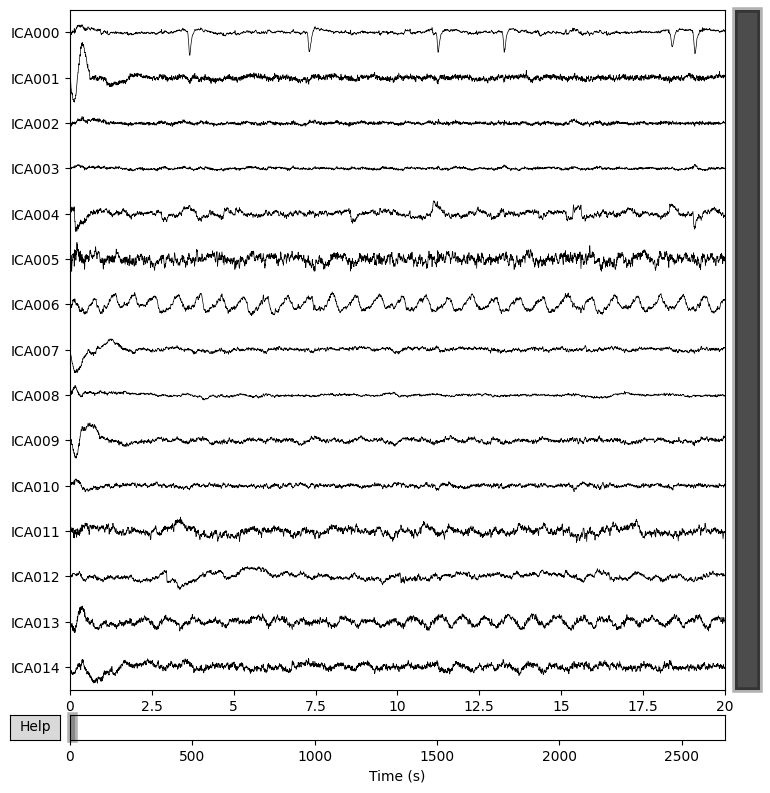

In [204]:
ica.plot_sources(eeg_notch)

### 各componentのtopographyの描画

In [205]:
ica.plot_components(inst=eeg_notch)

[<MNEFigure size 975x731 with 15 Axes>]

## 手動でICA componentsを除去

In [206]:
ica.exclude = [0, 6]

eeg_recon = eeg_notch.copy()
ica.apply(eeg_recon)

<RawArray | 32 x 669067 (2676.3 s), ~163.4 MB, data loaded>

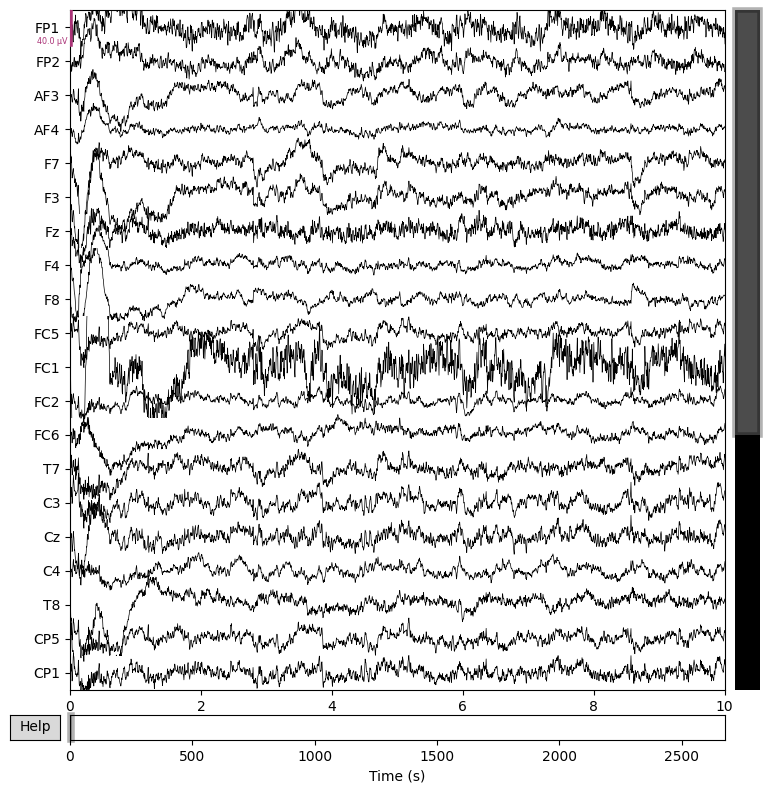

In [207]:
eeg_recon.plot()

## Save

In [208]:
ica.save(save_path + "solution-ica.fif")

np.savez(save_path + "eeg.npz", eeg=eeg_recon.get_data(), times=eeg_times)

ica.plot_components(inst=eeg_notch)[0].savefig(save_path + "ica_components.png")
ica.plot_sources(eeg_notch, start=20).savefig(save_path + "ica_sources.png")